In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import scikitplot
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

### Si procede alla scrittura ed esecuzione degli algoritmi di classificazione. Iniziando dal Decision Tree 

In [67]:
df = pd.read_csv('ravdess_features_base.csv')

Per prima cosa si binarizzano tutte le variabili categoriche che sono presenti nel dataset al fine di poterle utilizzare 
nell'algoritmo di Hunt. 

In [68]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [69]:
sexes = sorted(df['sex'].unique())
genders_mapping = dict(zip(sexes, range(0, len(sexes) + 1)))
df['sex_dumm'] = df['sex'].map(genders_mapping).astype(int)

In [70]:
statements = sorted(df['statement'].unique())
stat_mapping = dict(zip(statements, range (0, len(statements) + 1)))
df['statements_bin'] = df['statement'].map(stat_mapping).astype(int)

In [71]:
emotion_int = sorted(df['emotional_intensity'].unique())
emotion_mapping = dict(zip(emotion_int, range (0, len(emotion_int) + 1)))
df['emo_int'] = df['emotional_intensity'].map(emotion_mapping).astype(int)

In [72]:
voc_chan = sorted(df['vocal_channel'].unique())
voc_chan_mapping = dict(zip(voc_chan, range (0, len(voc_chan) + 1)))
df['voc_chan'] = df['vocal_channel'].map(voc_chan_mapping).astype(int)

In [73]:
rep = sorted(df['repetition'].unique())
rep_mapping = dict(zip(rep, range (0, len(rep) + 1)))
df['rep_int'] = df['repetition'].map(rep_mapping).astype(int)

In [74]:
cat_col = ['emotional_intensity', 'statement', 'repetition', 'sex', 'vocal_channel']
df.drop(cat_col, axis = 1, inplace = True)

#si elimina la versione categorica delle colonne che sono state binarizzate

A questo punto possiamo procedere alla scrittura del codice che ci permette di implementare l'algoritmo di Hunt. 

Come variabile target si sceglie "emotion" e si divide il dataset in 3 macro parti: train, validation e test. 

In [75]:
target = 'emotion'
columns = [c for c in df.columns if c != target and c != cat_col]

In [76]:
X = df[columns].values
y = df[target].values

In [77]:
df[target].value_counts()

emotion
fearful      376
angry        376
happy        376
calm         376
sad          376
surprised    192
disgust      192
neutral      188
Name: count, dtype: int64

In [13]:
df[target].value_counts()/len(df)

emotion
fearful      0.153344
angry        0.153344
happy        0.153344
calm         0.153344
sad          0.153344
surprised    0.078303
disgust      0.078303
neutral      0.076672
Name: count, dtype: float64

Si visualizza la distribuzione dellla variabile target all'interno del dataset. Si può prevedere che ci saranno difficoltà dal momento che le ultime 
tre non sono distribuite in maniera omogenea rispetto alle altre. 

In [78]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0) #divido train e validation dal test

In [79]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.3, stratify = y_train_val, random_state = 0) #divido train da validation

In [16]:
len(X_train), len(X_val), len(X_test), len(y_train), len(y_val)

(1201, 515, 736, 1201, 515)

Dopo aver diviso il dataset, si può procedere alla classificazione, chiamando il metodo di sklearn, DecisionTreeClassifier. 

Se ne effettua la chiamata sul train e validation con parametri di base, per avere una prima idea della performance. 

In [17]:
clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    ccp_alpha=0.0,
    random_state=0
)

In [18]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [19]:
y_pred = clf.predict(X_val)
accuracy_score(y_val, y_pred)

0.3825242718446602

Questa prova dimostra che c'è bisogno di trovare parametri di classificazione migliori poiché l'accuracy è molto bassa, non arrivando 
nemmeno al 50. Tuttavia considerando la distribuzione della variabile target supera comunque il minimo del 0.153344 necessario per affermare che l'algoritmo va comunque meglio del classificatore banale che risponde sempre 'fearful' ad esempio.

In [20]:
clf.classes_

array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad',
       'surprised'], dtype=object)

Si visualizza l'albero decisionale

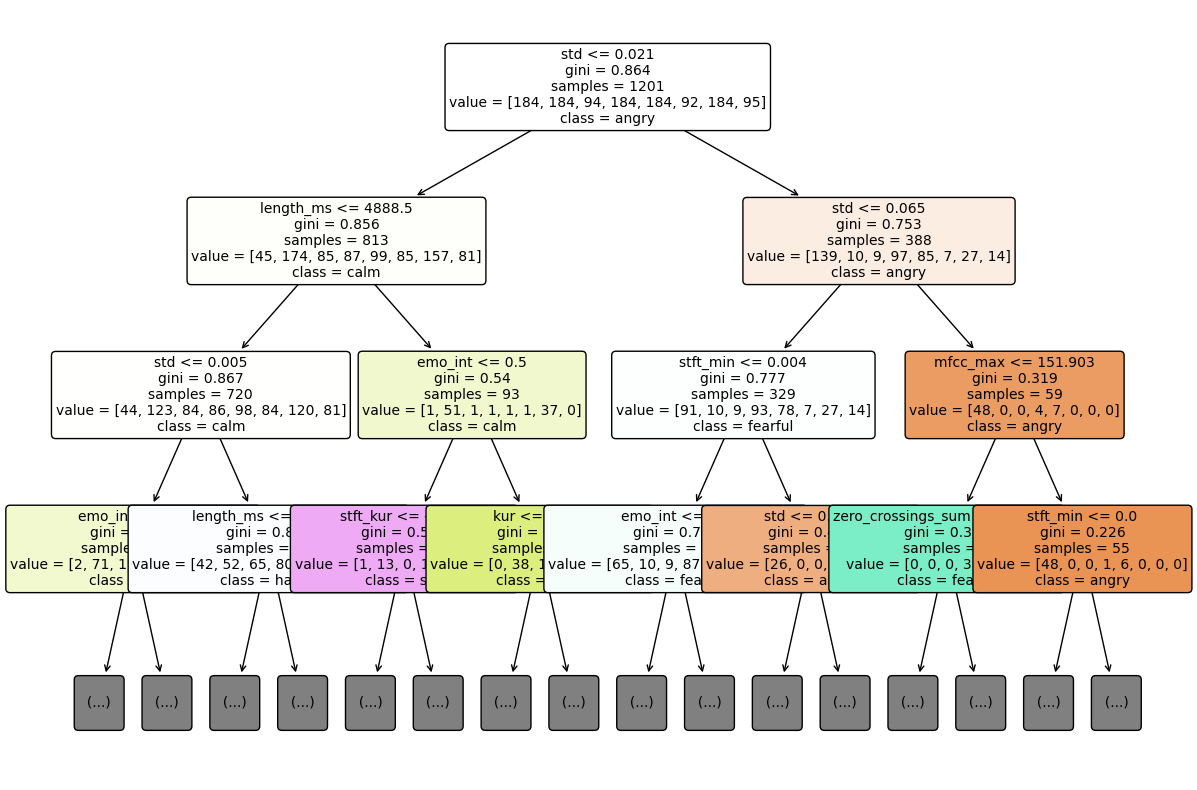

In [21]:
plt.figure(figsize=(14, 10))
plot_tree(clf,
          feature_names=columns,
          class_names=clf.classes_,
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3
          )
plt.show()

Questo albero individua come prima variabile su cui splittare std, che continua a comparire lungo tutto l'abero, quindi ci suggerisce che questa variabile risulta essere molto rilevante per la classificazione. Inoltre osserviamo che, come ci aspettiamo, l'algoritmo ad ogni step effettua greedy choices e infatti già al terzo livello notiamo delle foglie con già un buon grado di purezza.

Si studia la Learning Curve del nostro dataset. Questo parametro ci dirà quale può essere la grandezza del nostro 
training set necessaria a raggiungere un sufficiente grado di accuratezza. 

Di seguito si visualizza la learning curve. 

In [23]:
accuracy_mean_list = list()
accuracy_std_list = list()
for p in np.arange(0.1, 1.0, 0.1):
    accuracy_list_p = list()
    for i in range(0,10):
        index = np.random.choice(np.arange(0, len(X_train)), int(len(X_train)*p), replace = False)
        clf = DecisionTreeClassifier(
            criterion='gini',
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            ccp_alpha=0.0,
            random_state=0
        )
        clf.fit(X_train[index], y_train[index])

        y_pred = clf.predict(X_val)
        accuracy_list_p.append(accuracy_score(y_val, y_pred))
    accuracy_mean_list.append(np.mean(accuracy_list_p))
    accuracy_std_list.append(np.std(accuracy_list_p))

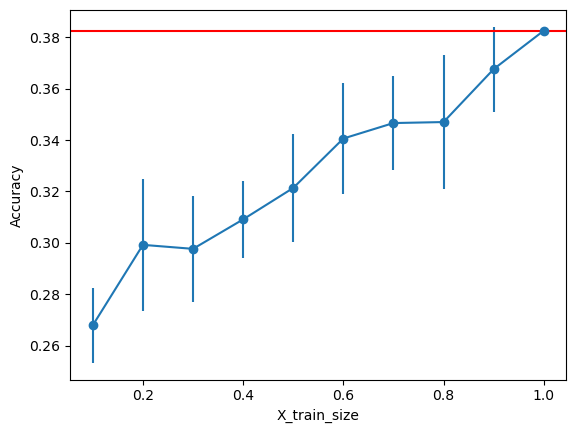

In [24]:
accuracy_mean_list.append(0.3825242718446602)
accuracy_std_list.append(0)
plt.errorbar(x= np.arange(0.1, 1.0+0.1, 0.1), y= accuracy_mean_list, yerr= accuracy_std_list, marker = 'o')
plt.axhline(y=0.3825242718446602, color='r')
plt.ylabel('Accuracy')
plt.xlabel('X_train_size')
plt.show()

Dalla learning curve osserviamo che l'accuracy è crescente (come ci aspettiamo) all'aumentare delle dimensioni del training set. In base agli scopi un'accuracy soddisfacente si potrebbe già raggiungere al 70% o al 90%, dove la standard deviation risulta anche più contenuta.

Attraverso un ciclo for, si calcola quale è il miglior parametro da imporre sul numero minimo di valori per foglia.

In [28]:
min_sample_leaf_list = np.arange(1, 80+1, 1)

In [29]:
accuracy_val_list = list()
accuracy_train_list = list()
for min_sample_leaf in min_sample_leaf_list:
    clf = DecisionTreeClassifier(
            criterion='gini',
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=min_sample_leaf,
            ccp_alpha=0.0,
            random_state=0
        )
    
    clf.fit(X_train[index], y_train[index])

    y_pred = clf.predict(X_val)
    accuracy_val_list.append(accuracy_score(y_val, y_pred))

    y_pred_train = clf.predict(X_train)
    accuracy_train_list.append(accuracy_score(y_train, y_pred_train))

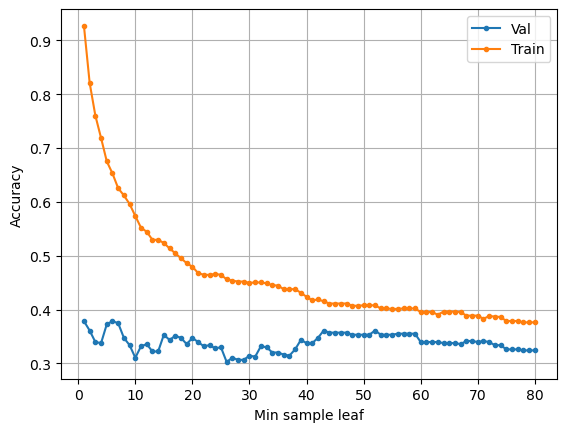

In [30]:
plt.plot(min_sample_leaf_list, accuracy_val_list, label = 'Val', marker = '.')
plt.plot(min_sample_leaf_list, accuracy_train_list, label = 'Train', marker = '.')
plt.ylabel('Accuracy')
plt.xlabel('Min sample leaf')
plt.grid()
plt.legend()
plt.show()

Per un min_samples_leaf piccolo il modello è in overfitting, mentre notiamo che all'aumentare di questo parametro l'overfitting rimane ma si riduce. Inoltre notiamo che l'accuracy migliore sul validation si ottiene quando min_samples_leaf=1 o 6, poi ha un andamento altalenanate, e infine sembra stabilizzarsi verso min_samples_leaf=42.

Attraverso un ciclo for, si calcola quale è il miglior parametro da imporre sul numero minimo di valori perché venga effettuato uno split su un nodo.

In [31]:
min_sample_split_list = np.arange(2,80+1, 1)
accuracy_val_list = list()
accuracy_train_list = list()
for min_sample_split in min_sample_split_list:
    clf = DecisionTreeClassifier(
            criterion='gini',
            max_depth=None,
            min_samples_split=min_sample_split,
            min_samples_leaf=1,
            ccp_alpha=0.0,
            random_state=0
        )
    
    clf.fit(X_train[index], y_train[index])

    y_pred = clf.predict(X_val)
    accuracy_val_list.append(accuracy_score(y_val, y_pred))

    y_pred_train = clf.predict(X_train)
    accuracy_train_list.append(accuracy_score(y_train, y_pred_train))

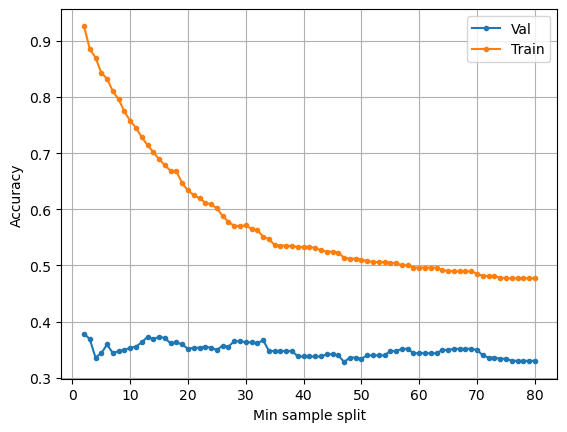

In [32]:
plt.plot(min_sample_split_list, accuracy_val_list, label = 'Val', marker = '.')
plt.plot(min_sample_split_list, accuracy_train_list, label = 'Train', marker = '.')
plt.ylabel('Accuracy')
plt.xlabel('Min sample split')
plt.grid()
plt.legend()
plt.show()

La situazione di overfitting rimane anche al crescere del parametro min_samples_split.  Mentre l'accuracy sul validation rimane essenzialmente costante.

Attraverso un ciclo for, si calcola quale è il miglior parametro da imporre sulla profondità massima dell'albero.

In [35]:
max_depth_list = np.arange(1,20+1, 1).tolist()+[None]
accuracy_val_list = list()
accuracy_train_list = list()
for max_depth in max_depth_list:
    clf = DecisionTreeClassifier(
            criterion='gini',
            max_depth=max_depth,
            min_samples_split=2,
            min_samples_leaf=1,
            ccp_alpha=0.0,
            random_state=0
        )
    
    clf.fit(X_train[index], y_train[index])

    y_pred = clf.predict(X_val)
    accuracy_val_list.append(accuracy_score(y_val, y_pred))

    y_pred_train = clf.predict(X_train)
    accuracy_train_list.append(accuracy_score(y_train, y_pred_train))

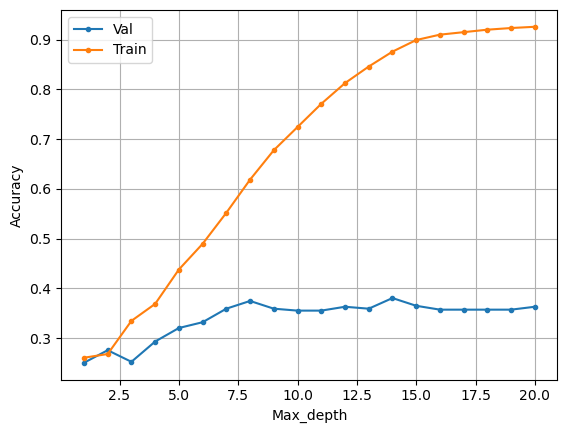

In [36]:
plt.plot(max_depth_list, accuracy_val_list, label = 'Val', marker = '.')
plt.plot(max_depth_list, accuracy_train_list, label = 'Train', marker = '.')
plt.ylabel('Accuracy')
plt.xlabel('Max_depth')
plt.grid()
plt.legend()
plt.show()

All'inizio l'overfitting è basso e l'accuracy di training e validation cresce in modo simile, poi verso max_depth=7 l'accuracy sul validation si stabilizza, mentre quella sul training continua ad aumentare.

Dal momento che manualmete non è stato possibile individuare degli iperparametri dirimenti, ci si rifà alla GridSearch e alla RandomizedSearch. 

Tuttavia, si eseguirà solo la RandomizedSearch dal momento che ha un costo computazionle di granlunga inferiore e ci permette di testare su un range di parametri più ampio. 

In [37]:
param_dict = { 
    'max_depth': np.arange(1,10+1, 1).tolist()+[None],
    'min_samples_split': np.arange(2,80+1, 1),
    'min_samples_leaf': np.arange(1, 80+1, 1),
    'ccp_alpha': np.arange(0.0, 0.1, 0.01)
}

In [38]:
# Qui si riporta il codice di GridSearch che non viene eseguito a causa del suo elevato costo computazionale. Si preferisce la RandomizedSearch
# come indicato a lezione. 

# clf = DecisionTreeClassifier(
#     criterion='gini',
#     max_depth=None,
#     min_samples_split=2,
#     min_samples_leaf=1,
#     ccp_alpha=0.0,
#     random_state=0
# )
# grid = GridSearchCV(clf, param_dict, cv = 3, scoring = 'accuracy', refit = True)
# grid.fit(X_train_val, y_train_val)

In [41]:
clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    ccp_alpha=0.0,
    random_state=0
)
rands = RandomizedSearchCV(clf, param_dict,cv = 5, scoring = 'accuracy', refit = True, n_iter = 5000, verbose=0)

rands.fit(X_train_val, y_train_val)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
                   n_iter=5000,
                   param_distributions={'ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, None],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 4...
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])},
                   scoring='accuracy')

In [82]:
#pickle.dump(rands, open('dt_randsearch.pickle', 'wb'))
clf = pickle.load(open('dt_randsearch.pickle', 'rb'))

In [45]:
rands.best_params_

{'min_samples_split': 13,
 'min_samples_leaf': 5,
 'max_depth': None,
 'ccp_alpha': 0.0}

In [46]:
clf = rands.best_estimator_

0.4171195652173913

In [83]:
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.4171195652173913

In [95]:
a = round(accuracy_score(y_test, y_pred), 2) # per il report finale

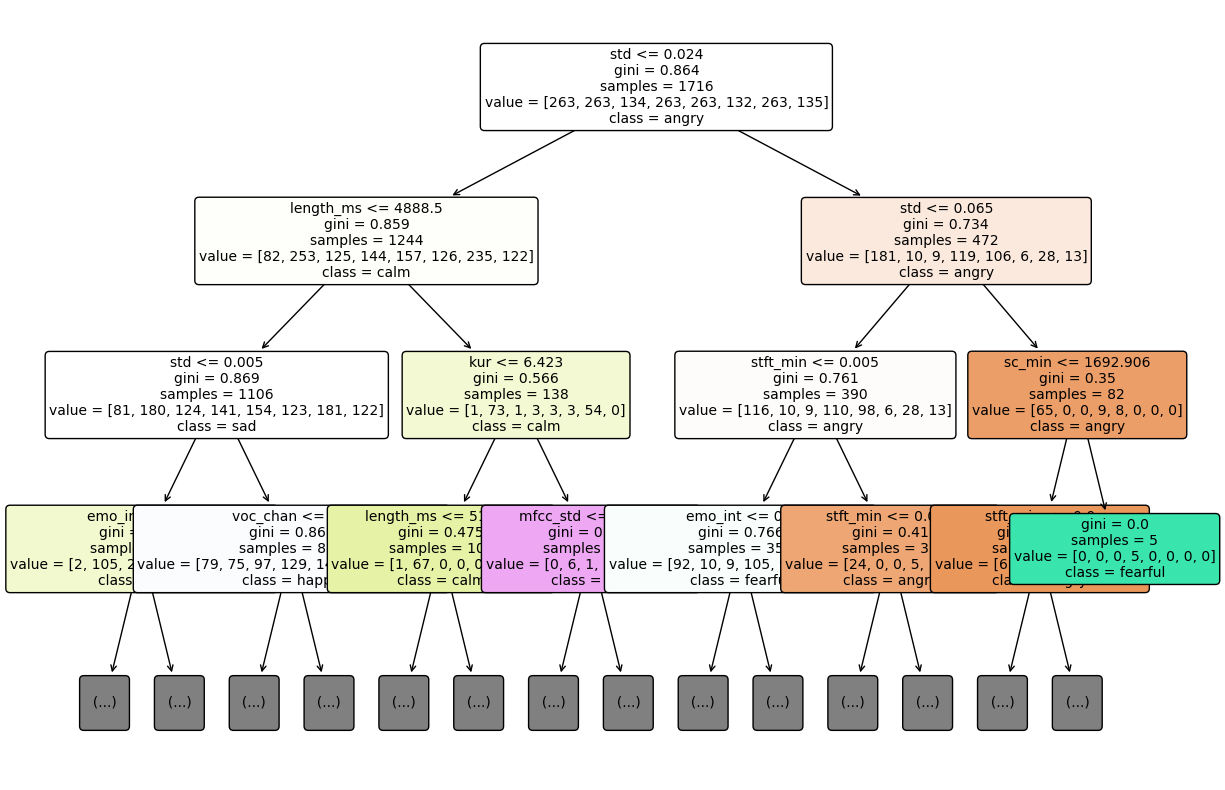

In [47]:
plt.figure(figsize=(14, 10))
plot_tree(clf,
          feature_names=columns,
          class_names=clf.classes_,
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3
          )
plt.show()

Si visualizza il bar plot delle feature più importanti nella costruzione dell'albero

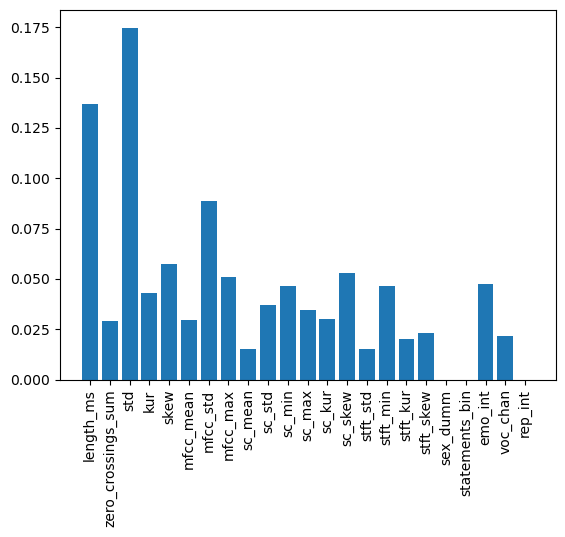

In [48]:
plt.bar(columns, clf.feature_importances_)
plt.xticks(rotation=90)
plt.show()

Come avevamo già notato dal primo albero std è la variabile più importante, seguita da length_ms e mfcc_std. Questo può essere coerente con il nostro task di individuazione dell'emozione perché in effetti ci aspettiamo che la deviazione standard media sia una variabile sensibile all'emozione con cui la frase è pronunciata (ad esempio supponiamo che in generale uno statement pronunciato con emozione neutral abbia una std minore rispetto a uno statement pronunciato con emozione angry). Osserviamo anche che sex, statement e repetition non sono feature rilevanti per la classificazione, e questo è coerente con quello che ci aspettiamo.

In [50]:
cf = confusion_matrix(y_test, y_pred)
accuracy_score_x_class = cf.diagonal()/cf.sum(axis=1)
accuracy_score_x_class

array([0.47787611, 0.65486726, 0.18965517, 0.46017699, 0.30973451,
       0.375     , 0.32743363, 0.40350877])

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.50      0.58      0.54       113
        calm       0.45      0.60      0.52       113
     disgust       0.28      0.26      0.27        58
     fearful       0.41      0.44      0.43       113
       happy       0.34      0.23      0.27       113
     neutral       0.32      0.34      0.33        56
         sad       0.45      0.33      0.38       113
   surprised       0.44      0.44      0.44        57

    accuracy                           0.42       736
   macro avg       0.40      0.40      0.40       736
weighted avg       0.41      0.42      0.41       736



In [94]:
b = round(precision_score(y_test, y_pred, average='macro'), 2) 
round(precision_score(y_test, y_pred, average='macro'), 2) 

0.41

calm è una delle emozioni che l'albero riesce a predirre meglio rispetto alle misure di accuracy, precision e recall. Comunque c'è da osservare che calm è fra le emozioni più abbondanti nel training set e quindi l'algoritmo ha potuto allenarsi meglio rispetto a questa emozione. Per contro le emozioni predette peggio sono disgust e neutral, che sono anche quelle con un supporto minore. Risulta quindi abbastanza sorprendente la performance superiore alla media di surprised. Questo forse può essere ricollegato al clustering che avevamo prodotto con il complete linkage, in cui vedevamo che i record surprised appartenevano quasi tutti allo stesso cluster, il che può suggerire che questi punti hanno delle caratteristiche specifiche e individualizzanti.

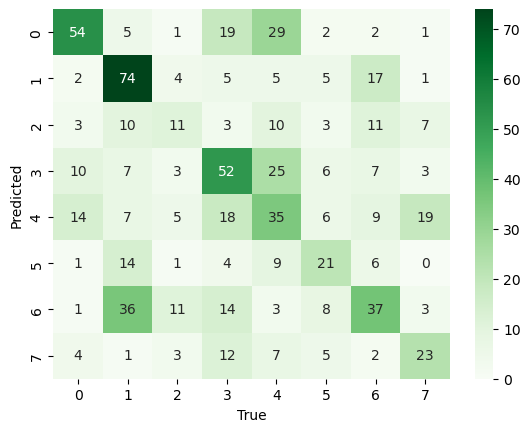

In [51]:
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [52]:
y_test_pred_proba = clf.predict_proba(X_test)

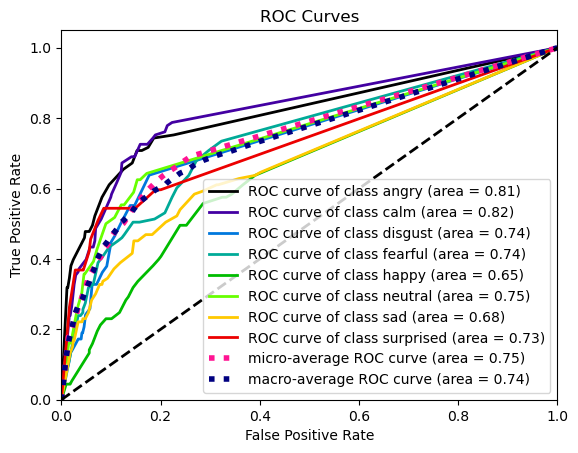

0.740662327487014


In [54]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

angry e calm si confermano essere le variabili a cui corrispondono le performance migliori. Tuttavia le altre mostrano un comportamento abbastanza sorprendente, nel senso che le emozioni con un supporto più piccolo riescono comunque ad avere un valore di area migliore rispetto a sad e happy.

# Random Forest

In [87]:
pd.set_option('display.max_columns', None)

In [96]:
df = pd.read_csv('ravdess_features_base.csv')
df = df.drop(columns=["Unnamed: 0"])
df_copy = df.copy()

In [97]:
df.columns

Index(['length_ms', 'zero_crossings_sum', 'std', 'kur', 'skew', 'mfcc_mean',
       'mfcc_std', 'mfcc_max', 'sc_mean', 'sc_std', 'sc_min', 'sc_max',
       'sc_kur', 'sc_skew', 'stft_std', 'stft_min', 'stft_kur', 'stft_skew',
       'vocal_channel', 'emotion', 'emotional_intensity', 'statement',
       'repetition', 'sex'],
      dtype='object')

In [98]:
continuous_col = ['length_ms', 'frame_count', 'intensity', 'zero_crossings_sum', 'mean', 'std', 'min', 'max', 'kur', 
                      'skew', 'mfcc_mean', 'mfcc_std', 'mfcc_min', 'mfcc_max', 'sc_mean', 'sc_std', 'sc_min', 'sc_max', 
                      'sc_kur', 'sc_skew', 'stft_mean', 'stft_std', 'stft_min', 'stft_max', 'stft_kur', 'stft_skew']
discrete_col = ['modality', 'vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 
                    'sex', 'channels', 'sample_width', 'frame_rate', 'frame_width']
continuous_col_to_delete = ['frame_count', 'mean', 'stft_max', 'min', 'max', 'stft_mean', 'mfcc_min']
continuous_col_to_keep = [col for col in continuous_col if col not in continuous_col_to_delete]
discrete_col_to_delete = ['modality', 'channels', 'sample_width', 'actor', 'frame_rate', 'frame_width']
discrete_col_to_keep = [col for col in discrete_col if col not in discrete_col_to_delete]

In [99]:
continuous_col_to_delete = ['frame_count', 'mean', 'stft_max', 'min', 'max', 'stft_mean', 'mfcc_min', 'intensity']
continuous_col_to_keep = [col for col in continuous_col if col not in continuous_col_to_delete]

In [9]:
# sc_min, vocal channel 

In [10]:
# df_train_val, df_test, y_train_val, y_test = train_test_split(df[columns], df[target], test_size=0.3, stratify=y, random_state=0)

In [11]:
# df['intensity'].hist()
# plt.show()

In [12]:
# null_index = np.argwhere(df['intensity'].isna().values).ravel()
# not_nullindex = np.argwhere(~df['intensity'].isna().values).ravel()

In [13]:
# X = df['mfcc_std'].values
# X_train = X[not_nullindex].reshape(-1, 1)
# y_train = df['intensity'].values[not_nullindex].reshape(-1, 1)
# X_test = X[null_index].reshape(-1, 1)

In [14]:
# reg = LinearRegression()
# reg.fit(X_train,y_train)

In [15]:
# intensity_pred = reg.predict(X_test)

In [16]:
# df.loc[null_index, 'intensity'] = intensity_pred
# df['intensity'].hist()
# plt.show()

In [17]:
# df['mfcc_std'].corr(df['intensity'])

In [20]:
# null_index_train_val = df_train_val['sc_min'].isna()
# null_index_test = df_test['sc_min'].isna()
# not_nullindex_train_val = ~df_train_val['sc_min'].isna()
# not_nullindex_test = ~df_test['sc_min'].isna()

In [21]:
# null_index_test

In [22]:
# reg = LinearRegression()
# reg.fit(df_reg_train,sc_min_reg_train)

In [23]:
# sc_min_train_pred = reg.predict(df_train_val.loc[null_index_train_val][['sc_mean', 'mfcc_max', 'zero_crossings_sum', 'mfcc_mean', 'sc_skew', 'sc_max']])

In [24]:
##sc_min_test_pred = reg.predict(df_test.loc[null_index_test][['sc_mean', 'mfcc_max', 'zero_crossings_sum', 'mfcc_mean', 'sc_skew', 'sc_max']])

In [25]:
# df_train_val.loc[null_index_train_val, 'sc_min'] = sc_min_train_pred

In [26]:
# df_temp = pd.concat([df_train_val, df_test], axis=0)

In [27]:
# df_temp['sc_min'].hist()

In questo codice commentato, allenavamo la regressione delle variabili sc_min e stft_min solo sul training set (esclusi i record dove quelle variabili erano missing), e usavamo il regressore ottenuto in questo modo per predirre sc_min e stft_min dove sono missing. Questo l'avevamo fatto onde evitare di introdurre un bias sul dataset. Però per semplicità abbiamo alla fine preferito mantere il dataset che avevamo già costruito.

In [100]:
df = df[discrete_col_to_keep + continuous_col_to_keep]

Come prima binarizziamo le variabili categoriche, impostiamo la variabile target e creiamo il training, validation e test set.

In [101]:
df['sex'] = df['sex'].map({'M': 0, 'F': 1})
df['repetition'] = df['repetition'].map({'1st': 0, '2nd': 1})
df['statement'] = df['statement'].map({'Dogs are sitting by the door': 0, 'Kids are talking by the door': 1})
df['emotional_intensity'] = df['emotional_intensity'].map({'normal': 0, 'strong': 1})
df['vocal_channel'] = df['vocal_channel'].map({'speech': 0, 'song': 1})

In [102]:
target = 'emotion'
columns = [c for c in df.columns if c != target]

In [103]:
X = df[columns].values
y = df[target].values

In [104]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [105]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, stratify=y_train_val, random_state=0)

# Test iperparametri

Testo gli iperparametri prima facendoli variare uno alla volta, e poi usando la GridSearch e la RandomizedSearch.

In [98]:
min_sample_leaf_list = np.arange(1, 50+1, 1)

In [99]:
accuracy_val_list = list()
accuracy_train_list = list()
for min_sample_leaf in min_sample_leaf_list:
    clf = RandomForestClassifier(
        n_estimators=20, #85
        criterion='gini',
        max_depth=None,
        min_samples_split=2, #6
        min_samples_leaf=min_sample_leaf,
        ccp_alpha=0.0,
        random_state=0
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    accuracy_val_list.append(accuracy_score(y_val, y_pred))

    y_pred_train = clf.predict(X_train)
    accuracy_train_list.append(accuracy_score(y_train, y_pred_train))

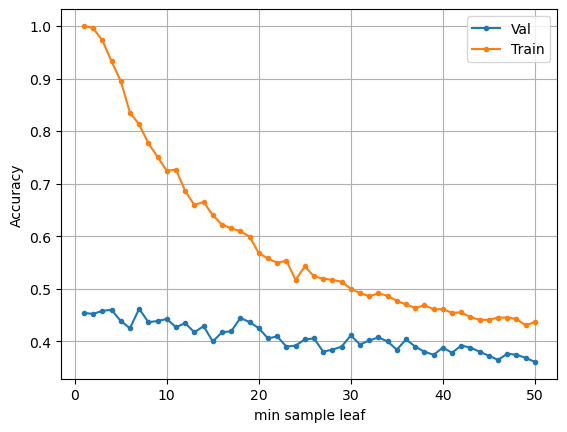

In [100]:
plt.plot(min_sample_leaf_list, accuracy_val_list, label='Val', marker='.')
plt.plot(min_sample_leaf_list, accuracy_train_list, label='Train', marker='.')
plt.ylabel('Accuracy')
plt.xlabel('min sample leaf')
plt.grid()
plt.legend()
plt.show()

In [101]:
min_sample_split_list = np.arange(2, 50+1, 1)

In [102]:
accuracy_val_list = list()
accuracy_train_list = list()
for min_sample_split in min_sample_split_list:
    clf = RandomForestClassifier(
        n_estimators=20,
        criterion='gini',
        max_depth=None,
        min_samples_split=min_sample_split,
        min_samples_leaf=1, # 1, 34
        ccp_alpha=0.0,
        random_state=0
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    accuracy_val_list.append(accuracy_score(y_val, y_pred))

    y_pred_train = clf.predict(X_train)
    accuracy_train_list.append(accuracy_score(y_train, y_pred_train))

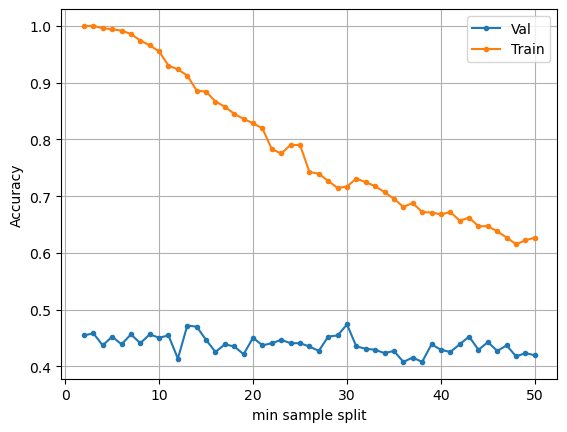

In [103]:
plt.plot(min_sample_split_list, accuracy_val_list, label='Val', marker='.')
plt.plot(min_sample_split_list, accuracy_train_list, label='Train', marker='.')
plt.ylabel('Accuracy')
plt.xlabel('min sample split')
plt.grid()
plt.legend()
plt.show()

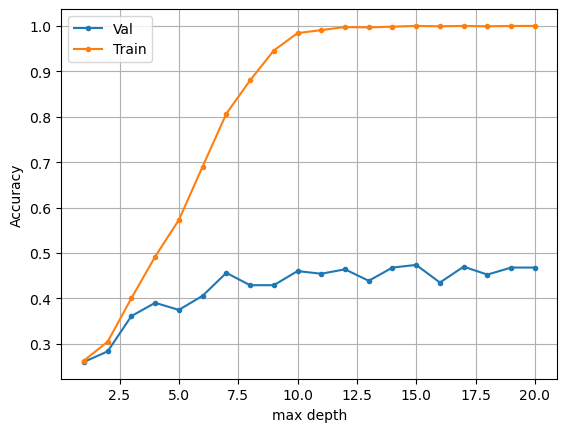

In [104]:
max_depth_list = np.arange(1, 20+1, 1).tolist() + [None]

accuracy_val_list = list()
accuracy_train_list = list()
for max_depth in max_depth_list:
    clf = RandomForestClassifier(
        n_estimators=20,
        criterion='gini',
        max_depth=max_depth,
        min_samples_split=2,
        min_samples_leaf=1, # 1, 34
        ccp_alpha=0.0,
        random_state=0
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    accuracy_val_list.append(accuracy_score(y_val, y_pred))

    y_pred_train = clf.predict(X_train)
    accuracy_train_list.append(accuracy_score(y_train, y_pred_train))

plt.plot(max_depth_list, accuracy_val_list, label='Val', marker='.')
plt.plot(max_depth_list, accuracy_train_list, label='Train', marker='.')
plt.ylabel('Accuracy')
plt.xlabel('max depth')
plt.grid()
plt.legend()
plt.show()

Osservando questi grafici notiamo che l'andamento generale riflette quanto già visto con un singolo albero decisionale, il che non ci stupisce troppo visto che la random forest è formata da alberi decisionali.

In [84]:
n_estimators_list = np.arange(10, 200+1, 1).tolist() 

accuracy_val_list = list()
accuracy_train_list = list()
for n_estimators in n_estimators_list:
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion='gini',
        max_depth=max_depth,
        min_samples_split=2,
        min_samples_leaf=1, # 1, 34
        ccp_alpha=0.0,
        random_state=0
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    accuracy_val_list.append(accuracy_score(y_val, y_pred))

    y_pred_train = clf.predict(X_train)
    accuracy_train_list.append(accuracy_score(y_train, y_pred_train))

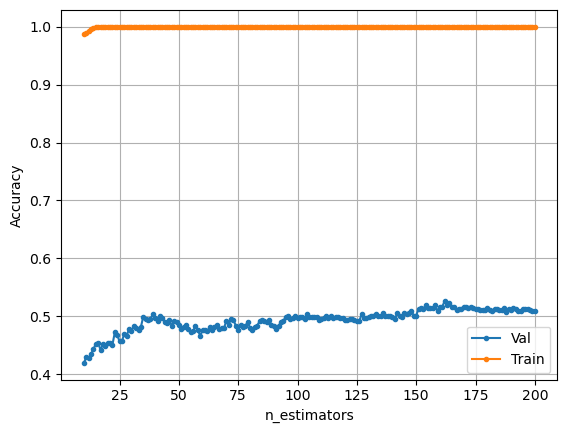

In [85]:
plt.plot(n_estimators_list, accuracy_val_list, label='Val', marker='.')
plt.plot(n_estimators_list, accuracy_train_list, label='Train', marker='.')
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.grid()
plt.legend()
plt.show()

Dal grafico dell'accuracy al variare del numero di alberi decisionali vediamo che l'accuracy sul validation risulta inizialmente crescente fino a n_estimators=40 circa, in cui si supera la soglia dello 0.5, poi la curva più o meno si stabilizza, quindi un numero di alberi ottimale potrebbe essere sui 40, in modo da avere l'accuracy migliore evitando di aumentare inutilmente il costo computazionale.
Per quanto riguarda l'accuracy sul train rimane altissima sin dall'inizio (il fatto che non decresca non stupisce perché), e quindi l'overfitting non va a decrescere.

# Random e Grid Search

In [76]:
param_dict = {
    'max_depth': np.arange(1, 20+1, 1).tolist() + [None],
    'min_samples_split': np.arange(2, 50+1, 1),
    'min_samples_leaf': np.arange(1, 50+1, 1),
    'ccp_alpha': np.arange(0.0, 0.1, 0.01)
}

param_dict2 = {
    'max_depth': [1,2,4,8, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4, 8],
    'ccp_alpha': np.arange(0.0, 0.1, 0.025)
}

In [77]:
clf_grid = RandomForestClassifier(
    n_estimators=20,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    ccp_alpha=0.0,
    random_state=0
)

In [78]:
grid = GridSearchCV(clf_grid, param_dict2, cv=5, scoring='accuracy', refit=True)
grid.fit(X_train_val, y_train_val)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=20, random_state=0),
             param_grid={'ccp_alpha': array([0.   , 0.025, 0.05 , 0.075]),
                         'max_depth': [1, 2, 4, 8, None],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 4, 8]},
             scoring='accuracy')

In [79]:
grid.best_params_

{'ccp_alpha': 0.0,
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [106]:
clf_grid = grid.best_estimator_
clf_grid.fit(X_train_val, y_train_val)
y_pred = clf_grid.predict(X_test)
accuracy_score(y_test, y_pred)

0.49728260869565216

Questa accuracy è più alta di quella che avevamo trovato testando la random forest al variare di min_samples_leaf, ma questo si spiega perché in questo caso abbiamo allenato il modello su X_train_val al posto di X_train, e X_train_val ha più record.

In [81]:
y_train_val_pred = clf_grid.predict(X_train_val)

In [82]:
accuracy_score(y_train_val_pred, y_train_val)

0.9900932400932401

L'accuracy sul train è estremamente alta e quindi c'è un forte overfitting, che potrebbe anche essere dovuta ad una quantità insufficiente di dati.

In [106]:
#pickle.dump(clf_grid, open('rf_grid_ravdess.pickle', 'wb'))
clf = pickle.load(open('rf_grid_ravdess.pickle', 'rb'))

In [115]:
a1 = round(accuracy_score(y_test, clf.predict(X_test)), 2)
b1 = round(precision_score(y_test, clf.predict(X_test), average='macro'), 2)

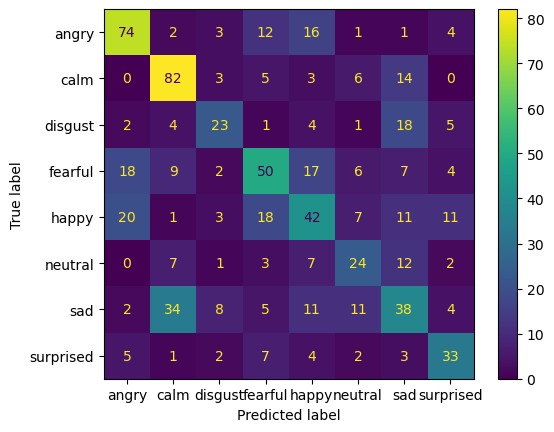

In [107]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=clf_grid.classes_)
disp.plot()
plt.show()

In [108]:
accuracy_score_x_class = cm.diagonal()/cm.sum(axis=1)
accuracy_score_x_class

array([0.65486726, 0.72566372, 0.39655172, 0.44247788, 0.37168142,
       0.42857143, 0.33628319, 0.57894737])

In [109]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

       angry      0.612     0.655     0.632       113
        calm      0.586     0.726     0.648       113
     disgust      0.511     0.397     0.447        58
     fearful      0.495     0.442     0.467       113
       happy      0.404     0.372     0.387       113
     neutral      0.414     0.429     0.421        56
         sad      0.365     0.336     0.350       113
   surprised      0.524     0.579     0.550        57

    accuracy                          0.497       736
   macro avg      0.489     0.492     0.488       736
weighted avg      0.490     0.497     0.491       736



Valgono commenti analoghi a quelli fatti per l'albero decisionale.

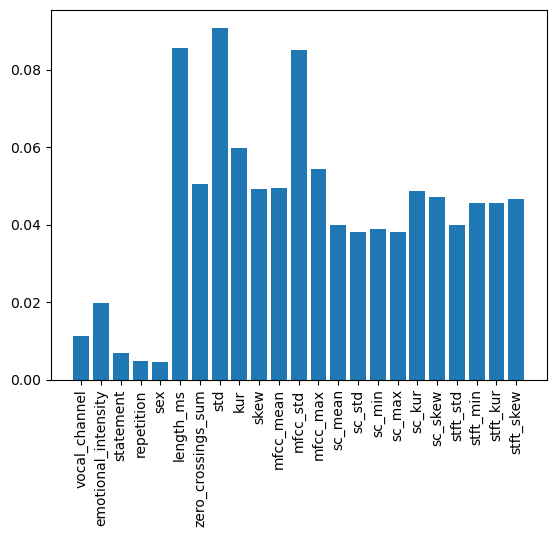

In [110]:
plt.bar(columns, clf_grid.feature_importances_)
plt.xticks(rotation=90)
plt.show()

Anche qui, come abbiamo visto con l'albero decisionale, le feature più importanti rimangono std, length_ms e mfcc_std, questo conferma le osservazioni precedenti. In questo caso notiamo che sex, repetition e statement hanno una feature importance maggiore di zero, questo succede perché nella random forest vengono usati sia alberi 'esperti' che non 'esperti', e quindi è possibile che queste variabili siano state utilizzate da questi ultimi.

Sotto faccio il plot di uno degli alberi della foresta.

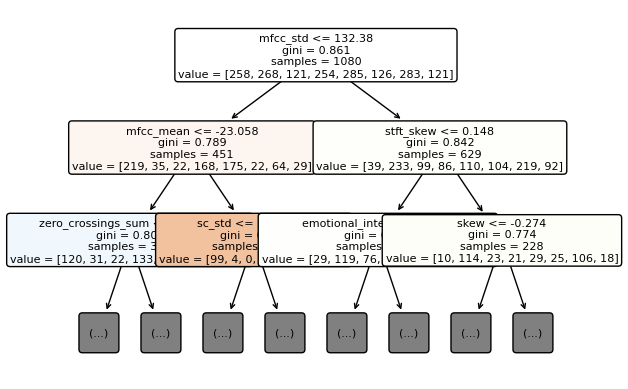

In [111]:
plot_tree(clf_grid.estimators_[0],
          feature_names=columns,
          #class_names=clf.classes_,
          filled=True,
          rounded=True,
          fontsize=8,
          max_depth=2
          )
plt.show()

In [112]:
y_pred_proba = clf_grid.predict_proba(X_test)

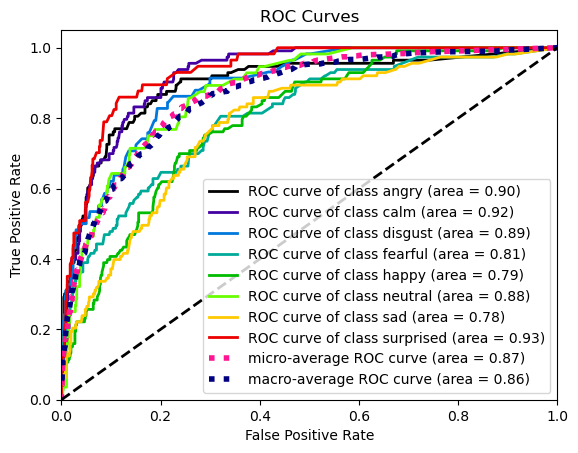

In [113]:
scikitplot.metrics.plot_roc(y_test, y_pred_proba)
plt.show()

Anche osservando la ROC, ritroviamo gli stessi pattern visti con l'albero decisionale.

In [114]:
clf = RandomForestClassifier(
    n_estimators=20,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    ccp_alpha=0.0,
    max_features='sqrt',
    random_state=0
)

In [115]:
rands = RandomizedSearchCV(clf, param_dict, cv=5, scoring='accuracy', refit=True, n_iter=100, random_state=0)
rands.fit(X_train_val, y_train_val)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_estimators=20,
                                                    random_state=0),
                   n_iter=100,
                   param_distributions={'ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20,
                                                      None],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
                   random_state=0, scoring='accuracy')

In [116]:
rands.best_params_

{'min_samples_split': 15,
 'min_samples_leaf': 7,
 'max_depth': 12,
 'ccp_alpha': 0.0}

In [117]:
clf = rands.best_estimator_
clf.fit(X_train_val, y_train_val)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.46059782608695654

Con la randomized search ho cercato i parametri ottimali su un dizionario molto più ampio rispetto a quello usato con la GridSearch, non siamo però riusciti a ottenere un'accuracy migliore a causa del basso n_iter scelto (selezionato per risparmiare tempo computazionale). Quindi per ottenere risultati migliori e più stabili andrebbe scelto un n_iter maggiore.

In [118]:
y_train_val_pred = clf_grid.predict(X_train_val)
accuracy_score(y_train_val_pred, y_train_val)

0.9900932400932401

In [119]:
pickle.dump(clf, open('rf_random_ravdess.pickle', 'wb'))
#clf2 = pickle.load(open('rf_random_ravdess.pickle', 'rb'))

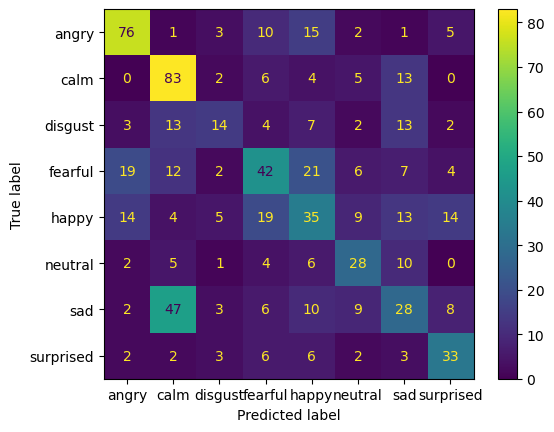

In [120]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [121]:
accuracy_score_x_class = cm.diagonal()/cm.sum(axis=1)
accuracy_score_x_class

array([0.67256637, 0.73451327, 0.24137931, 0.37168142, 0.30973451,
       0.5       , 0.24778761, 0.57894737])

In [77]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.482     0.487     0.485       113
           1      0.591     0.602     0.596       113
           2      0.325     0.336     0.330       113
           3      0.389     0.362     0.375        58
           4      0.513     0.357     0.421        56
           5      0.469     0.726     0.569       113
           6      0.308     0.248     0.275       113
           7      0.419     0.228     0.295        57

    accuracy                          0.442       736
   macro avg      0.437     0.418     0.418       736
weighted avg      0.436     0.442     0.431       736



In [125]:
pd.Series(y_pred[y_test == 'sad']).value_counts()

calm         47
sad          28
happy        10
neutral       9
surprised     8
fearful       6
disgust       3
angry         2
Name: count, dtype: int64

facciamo un'ulteriore verifica sulle predizioni che dovrebbero essere sad, e notiamo che viene come calm 47 volte contro 28 predizioni esatte. Quindi la random forest sta facendo molta fatica a predirre sad. Guardando la confusion matrix comunque si vede che sad è l'emozione che fa più fatica a predirre. Anche dal punto di vista semantico è comprensibile che queste emozioni vengano confuse.

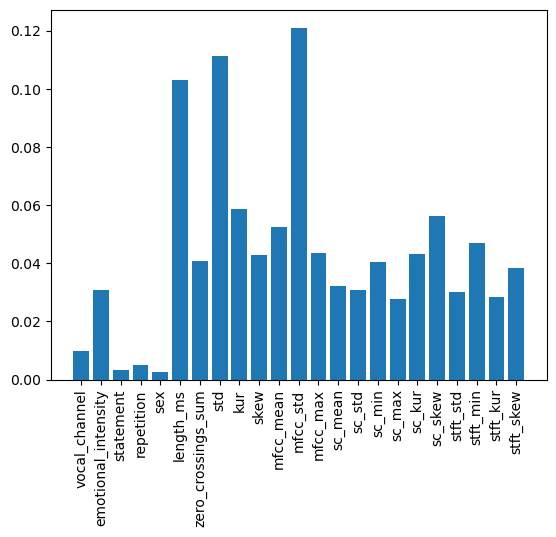

In [126]:
plt.bar(columns, clf.feature_importances_)
plt.xticks(rotation=90)
plt.show()

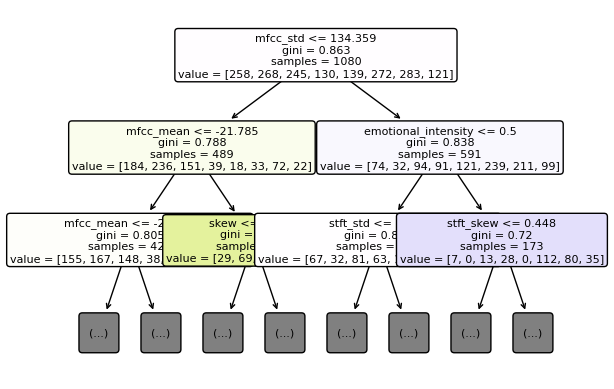

In [79]:
plot_tree(clf.estimators_[0],
          feature_names=columns,
          #class_names=clf.classes_,
          filled=True,
          rounded=True,
          fontsize=8,
          max_depth=2
          )
plt.show()

Per concludere:
- abbiamo ottenuto in generale risultati di accuracy più soddisfacenti rispetto all'albero decisionale
- all'aumentare della dimensione della foresta almeno inizialmente migliora l'accuracy
- per quanto riguarda la feature importance si riconferma quanto già osservato con l'albero decisionale
- la grid search ci ha permesso di trovare la configurazione di parametri migliore

# KNN

In [116]:
df = pd.read_csv('ravdess_features_base.csv', sep=',')

In [117]:
df_copy = df.copy()

In [118]:
df = df.drop(columns=["Unnamed: 0"])

In [119]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

In [120]:
target = 'emotion'
columns = [c for c in df.columns if c in numeric_columns]

In [121]:
X = df[columns].values
y = df[target].values

###### Standardizzazione

In [122]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

###### Divisione in training e test set

In [123]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42) #divido train e validation dal test

In [124]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.3, stratify = y_train_val, random_state = 42) #divido train da validation

In [125]:
X.shape, X_train_val.shape, X_train.shape, X_test.shape

((2452, 18), (1716, 18), (1201, 18), (736, 18))

In [126]:
np.unique(y, return_counts=True)[1]

array([376, 376, 192, 376, 376, 188, 376, 192], dtype=int64)

In [30]:
print(np.unique(y, return_counts=True)[1]/len(y))
print(np.unique(y_train_val, return_counts=True)[1]/len(y_train_val))
print(np.unique(y_train, return_counts=True)[1]/len(y_train))
print(np.unique(y_test, return_counts=True)[1]/len(y_test))

[0.15334421 0.15334421 0.07830343 0.15334421 0.15334421 0.0766721
 0.15334421 0.07830343]
[0.1532634  0.1532634  0.07808858 0.1532634  0.1532634  0.07692308
 0.1532634  0.07867133]
[0.15320566 0.15320566 0.07826811 0.15320566 0.15320566 0.07660283
 0.15320566 0.07910075]
[0.15353261 0.15353261 0.07880435 0.15353261 0.15353261 0.07608696
 0.15353261 0.07744565]


#### KNN

In [38]:
k_values = range(1, 21)
avg_scores_list = []
avg_train_scores_list = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_val, y_train_val)
    scores = cross_val_score(knn, X_train_val, y_train_val, cv=5, scoring='accuracy')
    train_scores = accuracy_score(knn.predict(X_train_val), y_train_val)
    avg_scores = np.mean(scores)  
    avg_scores_list.append(avg_scores)
    train_avg_scores = np.mean(train_scores)
    avg_train_scores_list.append(train_avg_scores)

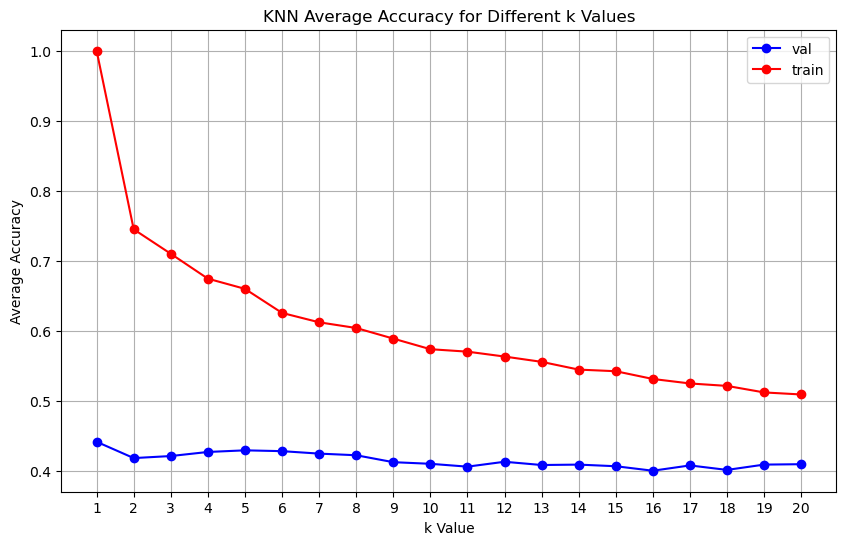

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, avg_scores_list, marker='o', linestyle='-', color='b', label='val')
plt.plot(k_values, avg_train_scores_list, marker='o', linestyle='-', color='r', label='train')
plt.legend()
plt.title('KNN Average Accuracy for Different k Values')
plt.xlabel('k Value')
plt.ylabel('Average Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Dopo aver calcolato l'accuracy media sul training e sul validation usando la cross validation, notiamo che l'accuracy sul validation massima si raggiunge con k=4, si ha anche un overfitting abbastanza contenuto.

In [172]:
knn_p = KNeighborsClassifier(n_neighbors=4)

In [173]:
knn_p.fit(X_train_val, y_train_val)

KNeighborsClassifier(n_neighbors=4)

In [174]:
y_pred = knn_p.predict(X_test)

#### Accuracy, Precision, Recall, F1

In [175]:
accuracy_score(y_test, y_pred)

0.4171195652173913

Testando il knn con k=4 sul test set otteniamo un'accuracy migliore della previsione fatta sul validation.

In [178]:
cf_matrix = confusion_matrix(y_test, y_pred)
accuracy_score_x_class = cf_matrix.diagonal()/cf_matrix.sum(axis=1)
accuracy_score_x_class

array([0.68141593, 0.5840708 , 0.39655172, 0.38053097, 0.33628319,
       0.21428571, 0.25663717, 0.33333333])

In [177]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

       angry      0.481     0.681     0.564       113
        calm      0.475     0.584     0.524       113
     disgust      0.319     0.397     0.354        58
     fearful      0.413     0.381     0.396       113
       happy      0.404     0.336     0.367       113
     neutral      0.261     0.214     0.235        56
         sad      0.426     0.257     0.320       113
   surprised      0.358     0.333     0.345        57

    accuracy                          0.417       736
   macro avg      0.392     0.398     0.388       736
weighted avg      0.411     0.417     0.406       736



#### Confusion Matrix

In [188]:
cf_matrix = confusion_matrix(y_test, y_pred)
class_labels = np.unique(y_test)

In [189]:
class_labels

array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad',
       'surprised'], dtype=object)

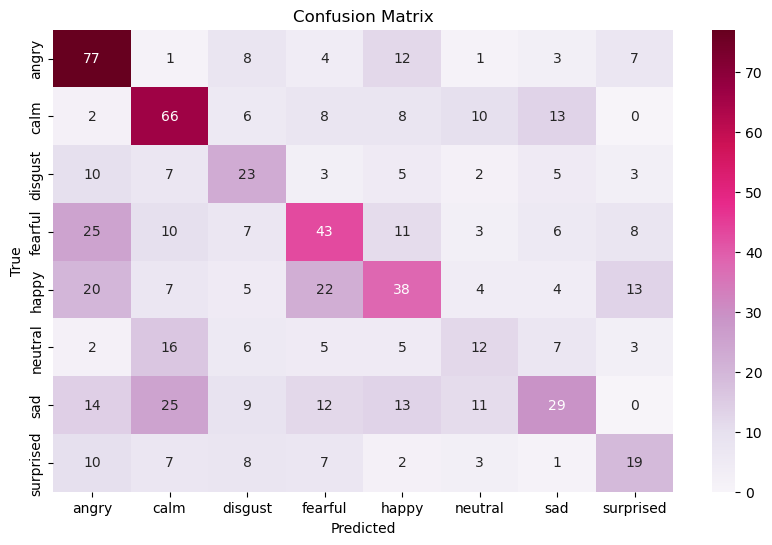

In [190]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='PuRd', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Anche in questo caso i risultati sono paragonabili a quelli ottenuti con le classificazioni precedenti.

#### Migliori Iperparametri

In [127]:
param_grid = {
    "n_neighbors": np.arange(1, 100),
    "metric": ["euclidean"]
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=42),
    n_jobs=-1,
    refit=True,
)
grid.fit(X_train_val, y_train_val)
clf = grid.best_estimator_
print("Best hyerparameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)


Best hyerparameters: {'metric': 'euclidean', 'n_neighbors': 1}
Best cross-validation score: 0.44444444444444436


In [42]:
test_score = clf.score(X_train_val, y_train_val)
print("Accuracy on the training set:", test_score)

Accuracy on the training set: 1.0


In [130]:
test_score = clf.score(X_test, y_test)
a2 = round(test_score, 2)
b2 = round(precision_score(y_test, clf.predict(X_test), average='macro'), 2)
print("Accuracy on the test set:", test_score)

Accuracy on the test set: 0.452445652173913


In questo caso vediamo che l'accuracy ottenuta con la repeated cross validation è una buona approssimazione dell'accuracy sul test. Inoltre otteniamo un'accuracy sul training uguale a 1, come ci aspettiamo perché n_neighbors = 1. Vista la forte discrepanza tra l'accuracy sul training e sul test, concludiamo che il modello soffre di un forte overfitting. Infine osserviamo che si confermano i risultati ottenuti in precedenza e visualizzati sul grafico.

In [45]:
y_pred = clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
accuracy_score_x_class = cf_matrix.diagonal()/cf_matrix.sum(axis=1)
accuracy_score_x_class

array([0.53982301, 0.59292035, 0.34482759, 0.38053097, 0.38938053,
       0.42857143, 0.39823009, 0.50877193])

In [46]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

       angry      0.635     0.540     0.584       113
        calm      0.593     0.593     0.593       113
     disgust      0.370     0.345     0.357        58
     fearful      0.350     0.381     0.364       113
       happy      0.411     0.389     0.400       113
     neutral      0.329     0.429     0.372        56
         sad      0.455     0.398     0.425       113
   surprised      0.408     0.509     0.453        57

    accuracy                          0.452       736
   macro avg      0.444     0.448     0.443       736
weighted avg      0.461     0.452     0.455       736



Sebbene il pattern dei risultati sia lo stesso di quello ottenuto con n_neighbors=4, osserviamo un generale miglioramento delle performance.

#### ROC Curve

In [43]:
y_pred_proba = clf.predict_proba(X_test)

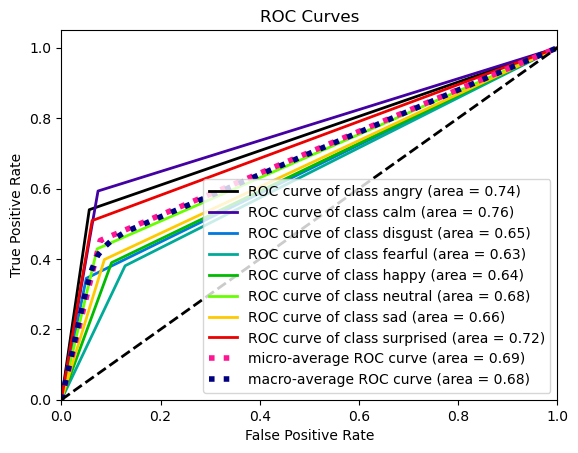

In [44]:
scikitplot.metrics.plot_roc(y_test, y_pred_proba)
plt.show()

Sebbene rimanga sopra la diagonale, questa roc curve risulta peggiore rispetto a quella ottenuta ad esempio con la random forest.

#### LIME EXlainer per la feature importance degli indici

In [50]:
from lime.lime_tabular import LimeTabularExplainer

feature_names = df.columns.tolist()

explainer = LimeTabularExplainer(X_train,
                                 feature_names = feature_names,
                                 class_names=clf.classes_,
                                 discretize_continuous=True)

instance_idx = 61 #Cambiando l'indice, si possono osservare le spiegazioni per ciascuna previsione

ex = explainer.explain_instance(X_test[instance_idx],
                                 clf.predict_proba,
                                 num_features=len(feature_names))

ex.show_in_notebook()

Dal plot di LIME, un metodo di Explainable AI per aprire la black box di KNN e valutare per ciascun indice una sorta di feature importance, si può evincere che "LimeTabularEXplainer" ha trasformato in variabile binaria CALM, dividendo così la classificazione. Inoltre, "emotion" figura come feature per la interpretabilità locale. 

Dal momento che i valori non risultano ottimali, possiamo provare ad utiizzare l'oversampling delle classi di "emotion", le quali hanno distribuzione diversa.

In [53]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print("Distribuzione prima dell'oversampling:")
print(Counter(y))

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nDistribuzione dopo l'versampling:")
print(Counter(y_resampled))

Distribuzione prima dell'oversampling:
Counter({'fearful': 376, 'angry': 376, 'happy': 376, 'calm': 376, 'sad': 376, 'surprised': 192, 'disgust': 192, 'neutral': 188})

Distribuzione dopo l'versampling:
Counter({'fearful': 376, 'angry': 376, 'happy': 376, 'surprised': 376, 'neutral': 376, 'calm': 376, 'sad': 376, 'disgust': 376})


In [54]:
Xr = X_resampled
yr = y_resampled

In [55]:
scaler = StandardScaler()
Xr = scaler.fit_transform(X_resampled)

In [56]:
Xr_train_val, Xr_test, yr_train_val, yr_test = train_test_split(Xr, yr, test_size=0.3, stratify=yr, random_state=42) #divido train e validation dal test

In [57]:
Xr_train, Xr_val, yr_train, yr_val = train_test_split(Xr_train_val, yr_train_val, test_size = 0.3, stratify = yr_train_val, random_state = 42) #divido train da validation

In [58]:
Xr.shape, Xr_train.shape, Xr_test.shape

((3008, 18), (1473, 18), (903, 18))

In [59]:
np.unique(yr, return_counts=True)[1]

array([376, 376, 376, 376, 376, 376, 376, 376], dtype=int64)

In [60]:
k_values = range(1, 21)
avg_scores_list = []
avg_train_scores_list = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xr_train_val, yr_train_val)
    scores = cross_val_score(knn, Xr_train_val, yr_train_val, cv=5, scoring='accuracy')
    train_scores = accuracy_score(knn.predict(Xr_train_val), yr_train_val)
    avg_scores = np.mean(scores)  
    avg_scores_list.append(avg_scores)
    train_avg_scores = np.mean(train_scores)
    avg_train_scores_list.append(train_avg_scores)

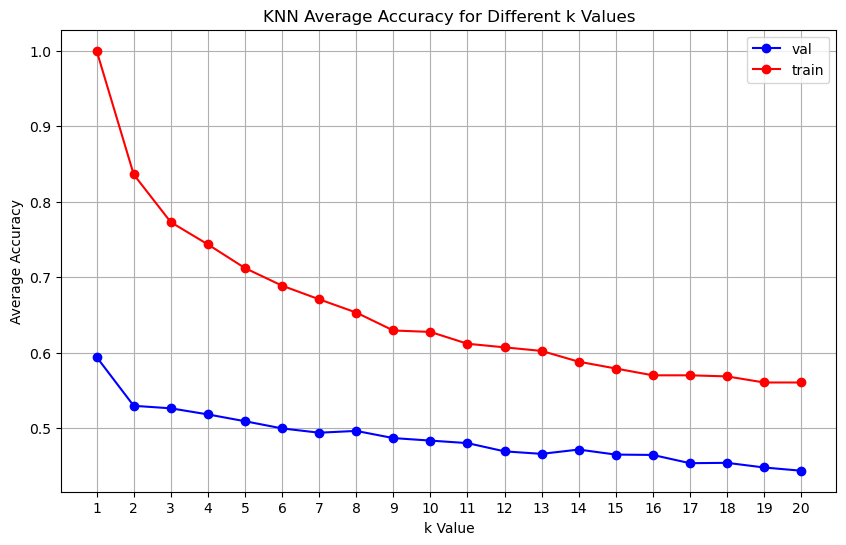

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, avg_scores_list, marker='o', linestyle='-', color='b', label='val')
plt.plot(k_values, avg_train_scores_list, marker='o', linestyle='-', color='r', label='train')
plt.legend()
plt.title('KNN Average Accuracy for Different k Values')
plt.xlabel('k Value')
plt.ylabel('Average Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Una buona scelta del k, tenendo in considerazione accuracy sul validation e overfitting, può essere k=8.

### KNN

In [62]:
knn = KNeighborsClassifier(n_neighbors=8)

In [63]:
knn.fit(Xr_train_val, yr_train_val)

KNeighborsClassifier(n_neighbors=8)

In [64]:
yr_pred = knn.predict(Xr_test)

## Accuracy, precision, recall, F1

In [65]:
accuracy_score(yr_test, yr_pred)

0.5227021040974529

Anche qui vediamo che l'accuracy sul validation è una buona approssimazione dell'accuracy sul test.

In [66]:
cf_matrix = confusion_matrix(yr_test, yr_pred)
accuracy_score_x_class = cf_matrix.diagonal()/cf_matrix.sum(axis=1)
accuracy_score_x_class

array([0.53982301, 0.47321429, 0.79646018, 0.36283186, 0.33628319,
       0.79646018, 0.15044248, 0.72566372])

In [202]:
print(classification_report(yr_test, yr_pred, digits=3))

              precision    recall  f1-score   support

       angry      0.526     0.637     0.576       113
        calm      0.463     0.504     0.483       113
     disgust      0.669     0.876     0.759       113
     fearful      0.432     0.310     0.361       113
       happy      0.388     0.230     0.289       113
     neutral      0.552     0.841     0.667       113
         sad      0.528     0.250     0.339       112
   surprised      0.713     0.770     0.740       113

    accuracy                          0.553       903
   macro avg      0.534     0.552     0.527       903
weighted avg      0.534     0.553     0.527       903



Osserviamo che le performance del modello relativamente alle varibili sui cui abbiamo effettuato l'oversampling sono sensibilmente aumentate rispetto alle altre che si sono mantenute più costanti. Questo ci può suggerire che potremmo aver introdotto un bias nel modello nella nostra applicazione dell'oversampling, quindi per quanto l'idea ci sia sembrata percorribile, non considereremo validi questi risultati.

# CONCLUSIONI

In [132]:
# Si produce dataframe contenente precision accuracy dei rispettivi algoritmi eseguiti 
# con gli iperparametri migliori individuati. Proprio ad un passo dall'invio del lavoro abbiamo 
# realizzato di non aver incluso la recall... ma ci si perdonerà per acer ceduto proprio alla 
# fine! 


data = {'measure': ['accuracy', 'precision'], # la precision è calcolata con average='macro'
        'decision tree': [a, b],
        'random forest': [a1, b1],
        'knn': [a2, b2]
        }

In [133]:
pd.DataFrame(data)

,measure,decision tree,random forest,knn
0,accuracy,0.42,0.50,0.45
1,precision,0.41,0.49,0.44


Già dal confronto tra le misure di accuratezza e precisione si può notare che i risultati migliori si ottengono quando usiamo come modello la Random Forest con i parametri che avevamo individuato tramite la grid search, proprio come già ci aspettavamo nelle osservazioni preliminari. Del resto il knn non si può avvalere delle variabili categoriche, mentre il decision tree può risultare un modello eccessivamente semplice, privo com'é dell'idea di wisdom of the crowd. Anche rispetto all'osservazione della ROC curve e della confusion matrix di random forest, deduciamo che quest'ultimo è l'algoritmo più performante. 

Va comunque sottolineato che la random forest, come anche gli altri due modelli, mantiene un alto overfitting con l'accuracy del train sempre maggiore dell'accuracy sul test; forse questo è dovuto anche alla dimensione (intesa come numero di record) del dataset che è troppo limitata per questo task.

In termini generali, come abbiamo osservato precedentemente, i vari modelli risultano più prestanti nell'individuazione di alcune classi di emotion rispetto ad altre. Questo, pensiamo, sia per motivi di distribuzione di queste classi (i.e., alcune coinvolgono più record di altre), sia probabilmente per motivi legati all'ambiguità interpretativa di emozioni umane a partire da oservazioni che fanno riferimento al solo ascolto: in questo senso, non è un caso che nella classificazione l'emozione "sad" venisse spesso confusa con quella "calm". Probabilmente, l'inclusione di più parametri permetterebbe dei risultati di classificazione migliori, sicuramente diversi. D'altro canto, anche nella comunicazione umana, certe emozioni vengono meglio veicolate attraverso espressioni non verbali (come gesti, movimenti del viso etc.).

Un'osservazione interessante si può fare sul valore "surprised" di emotion che, sebbene sia tra i valori che si presentano con frequenza minore, mantiene performance di classificazione al di sopra delle aspettative con tutti gli algoritmi, raggiungendo valori di precisione che si avvicinano a quelli di valori più presenti. Questo aspetto può forse essere collegato in qualche modo a quello che abbiamo notato al livello di clusterizzazione dove, nel caso del complete linkage, il valore "surprised" era presente in un solo cluster. 